In [1]:
from comp_features import generate_features
import pandas as pd
from train_model import train_kmeans, plot_market_regime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 你的 API Key
API_KEY = "ab746526067b62ac85bcf51ef80eae5a"

# 选择资产
ASSET = "USD"

# 读取数据
df = pd.read_excel(f"/Users/charlesxiong/Desktop/IBKR_algo/ode/data/{ASSET}/{ASSET}.xlsx")
df_nasdaq = pd.read_excel(f"/Users/charlesxiong/Desktop/IBKR_algo/ode/data/SPX/SPX.xlsx")[['DateTime', 'SPX']]
df_bond = pd.read_excel('/Users/charlesxiong/Desktop/IBKR_algo/ode/data/BBG AGG BOND/BBG AGG BOND.xlsx')[['DateTime', 'BBG AGG BOND']]

# 计算所有特征
df_features = generate_features(df, ASSET, API_KEY)
df_features = pd.merge(df_features, df_nasdaq, on='DateTime', how='left')
df_features = pd.merge(df_features, df_bond, on='DateTime', how='left')
df_features['Corr'] = df_features['SPX'].rolling(window=252, min_periods=150).corr(df_features['BBG AGG BOND'])

# 保存结果
df_features['Market_Regime_Num_Train'] = 0
df_features



,DateTime,USD,VIX,USD_returns,USD_mean_ret_5d,USD_mean_ret_10d,USD_mean_ret_21d,USD_mean_ret_120d,USD_downside_std_5d,USD_downside_std_10d,...,USD_sortino_10d,USD_sortino_21d,USD_sortino_120d,T10Y2Y_EWMA_10,DGS2_diff_EWMA_21,VIX_EWMA_63,SPX,BBG AGG BOND,Corr,Market_Regime_Num_Train
0,1990-01-01,93.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.061660,-0.004220,NaN,NaN,NaN,NaN,0
1,1990-01-02,94.29,NaN,0.011520,0.011520,0.011520,0.011520,0.011520,NaN,NaN,...,NaN,NaN,NaN,0.062256,-0.004220,NaN,NaN,NaN,NaN,0
2,1990-01-03,94.42,NaN,0.001378,0.010207,0.010841,0.011191,0.011462,NaN,NaN,...,NaN,NaN,NaN,0.061435,-0.001651,NaN,NaN,NaN,NaN,0
3,1990-01-04,92.52,NaN,-0.020328,0.006254,0.008754,0.010167,0.011279,NaN,NaN,...,NaN,NaN,NaN,0.061339,-0.002247,NaN,NaN,NaN,NaN,0
4,1990-01-05,92.85,NaN,0.003560,0.005906,0.008406,0.009953,0.011234,NaN,NaN,...,NaN,NaN,NaN,0.063258,-0.002823,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,2025-03-24,104.26,21.3,0.001632,-0.000006,-0.000591,-0.000530,-0.000033,0.004263,0.004017,...,-0.147246,-0.148637,-0.010586,0.280910,-0.003085,16.65975,5767.57,NaN,0.646844,0
8980,2025-03-25,104.18,21.3,-0.000768,-0.000105,-0.000603,-0.000538,-0.000037,0.004087,0.003972,...,-0.151872,-0.151374,-0.011971,0.285537,-0.005582,16.65975,5776.65,NaN,0.645026,0
8981,2025-03-26,104.55,21.3,0.003545,0.000368,-0.000325,-0.000405,-0.000016,0.004087,0.003972,...,-0.081934,-0.114048,-0.005267,0.291193,-0.004751,16.65975,5712.20,NaN,0.642981,0
8982,2025-03-27,104.07,21.3,-0.004602,-0.000276,-0.000612,-0.000541,-0.000043,0.003795,0.003831,...,-0.159704,-0.154918,-0.013882,0.299149,-0.004922,16.65975,5693.31,NaN,0.640974,0


In [3]:
# 选择特征和目标
feature_columns = [
    f"{ASSET}_mean_ret_5d", f"{ASSET}_mean_ret_21d", f"{ASSET}_mean_ret_10d", 
    f"{ASSET}_downside_std_5d", f"{ASSET}_downside_std_21d",
    f"{ASSET}_sortino_5d", f"{ASSET}_sortino_21d", f"{ASSET}_sortino_10d"
]

feature_columns_xgb = feature_columns + [            
    "T10Y2Y_EWMA_10", "DGS2_diff_EWMA_21", "VIX_EWMA_63", "Corr"]


df_result = df_features.copy()
df_result

,DateTime,USD,VIX,USD_returns,USD_mean_ret_5d,USD_mean_ret_10d,USD_mean_ret_21d,USD_mean_ret_120d,USD_downside_std_5d,USD_downside_std_10d,...,USD_sortino_10d,USD_sortino_21d,USD_sortino_120d,T10Y2Y_EWMA_10,DGS2_diff_EWMA_21,VIX_EWMA_63,SPX,BBG AGG BOND,Corr,Market_Regime_Num_Train
0,1990-01-01,93.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.061660,-0.004220,NaN,NaN,NaN,NaN,0
1,1990-01-02,94.29,NaN,0.011520,0.011520,0.011520,0.011520,0.011520,NaN,NaN,...,NaN,NaN,NaN,0.062256,-0.004220,NaN,NaN,NaN,NaN,0
2,1990-01-03,94.42,NaN,0.001378,0.010207,0.010841,0.011191,0.011462,NaN,NaN,...,NaN,NaN,NaN,0.061435,-0.001651,NaN,NaN,NaN,NaN,0
3,1990-01-04,92.52,NaN,-0.020328,0.006254,0.008754,0.010167,0.011279,NaN,NaN,...,NaN,NaN,NaN,0.061339,-0.002247,NaN,NaN,NaN,NaN,0
4,1990-01-05,92.85,NaN,0.003560,0.005906,0.008406,0.009953,0.011234,NaN,NaN,...,NaN,NaN,NaN,0.063258,-0.002823,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,2025-03-24,104.26,21.3,0.001632,-0.000006,-0.000591,-0.000530,-0.000033,0.004263,0.004017,...,-0.147246,-0.148637,-0.010586,0.280910,-0.003085,16.65975,5767.57,NaN,0.646844,0
8980,2025-03-25,104.18,21.3,-0.000768,-0.000105,-0.000603,-0.000538,-0.000037,0.004087,0.003972,...,-0.151872,-0.151374,-0.011971,0.285537,-0.005582,16.65975,5776.65,NaN,0.645026,0
8981,2025-03-26,104.55,21.3,0.003545,0.000368,-0.000325,-0.000405,-0.000016,0.004087,0.003972,...,-0.081934,-0.114048,-0.005267,0.291193,-0.004751,16.65975,5712.20,NaN,0.642981,0
8982,2025-03-27,104.07,21.3,-0.004602,-0.000276,-0.000612,-0.000541,-0.000043,0.003795,0.003831,...,-0.159704,-0.154918,-0.013882,0.299149,-0.004922,16.65975,5693.31,NaN,0.640974,0


✅ Processing: 1992-01-01 to 2007-01-01
✅ Final chosen penalty: 3, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 35, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.01785022884323073}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


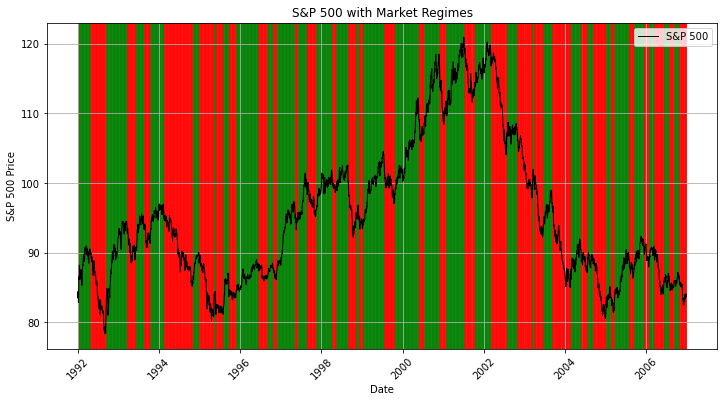

✅ Processing: 1992-07-01 to 2007-07-01
✅ Final chosen penalty: 3, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 5, 'learning_rate': 0.15000000000000002, 'strat_returns': -0.008144099094377633}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


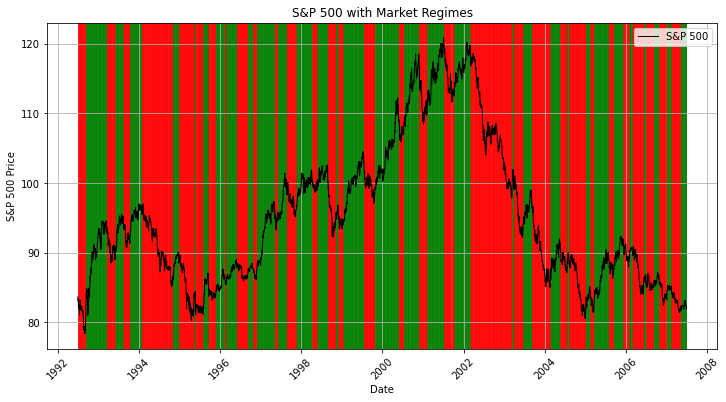

✅ Processing: 1993-01-01 to 2008-01-01
✅ Final chosen penalty: 2, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 5, 'learning_rate': 0.15000000000000002, 'strat_returns': -0.01860170301280728}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


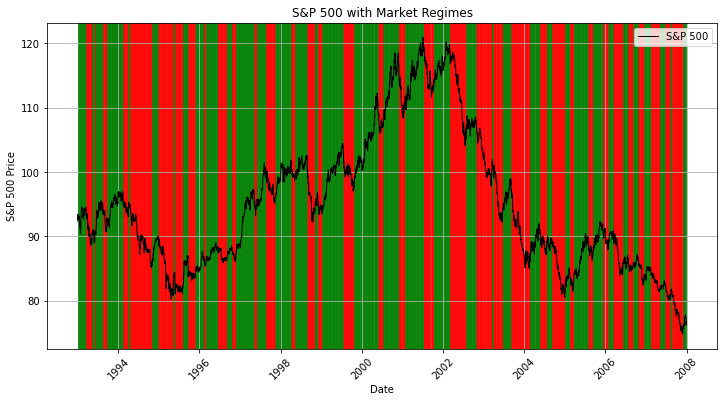

✅ Processing: 1993-07-01 to 2008-07-01
✅ Final chosen penalty: 3, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 5, 'learning_rate': 0.15000000000000002, 'strat_returns': -0.026538945226140642}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


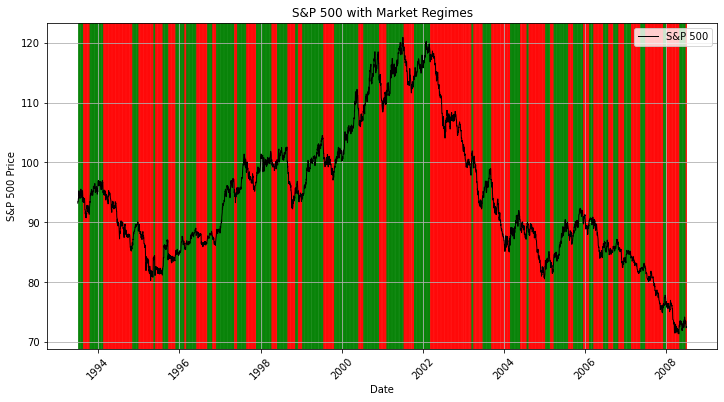

✅ Processing: 1994-01-01 to 2009-01-01
✅ Final chosen penalty: 1, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 15, 'learning_rate': 0.05, 'strat_returns': 0.1569474131192512}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


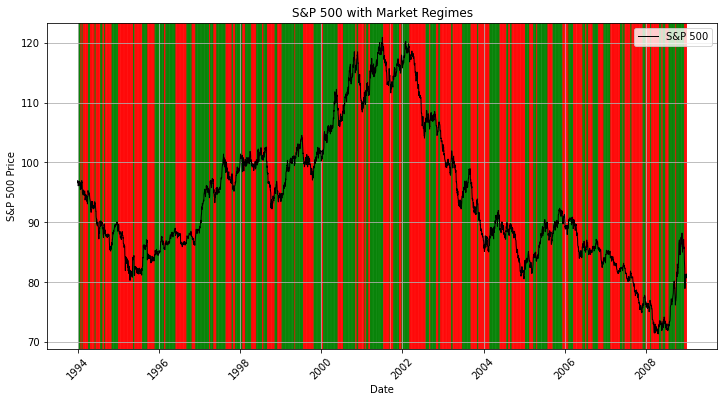

✅ Processing: 1994-07-01 to 2009-07-01
✅ Final chosen penalty: 1, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 0.05, 'strat_returns': 0.08695756824675893}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


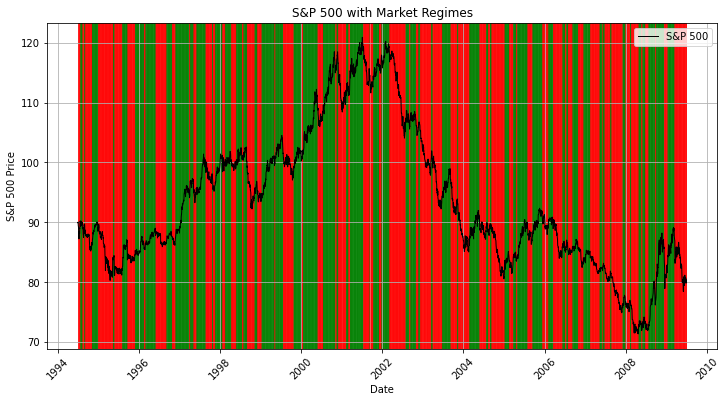

✅ Processing: 1995-01-01 to 2010-01-01
✅ Final chosen penalty: 2, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 0.05, 'strat_returns': 0.10959648721194792}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


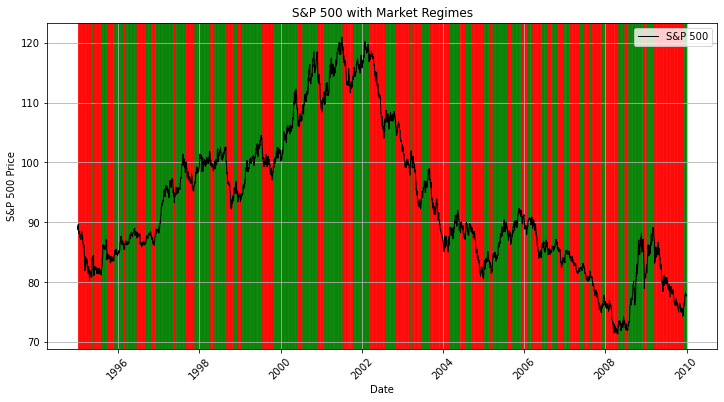

✅ Processing: 1995-07-01 to 2010-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 25, 'learning_rate': 0.05, 'strat_returns': 0.14731692734113966}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


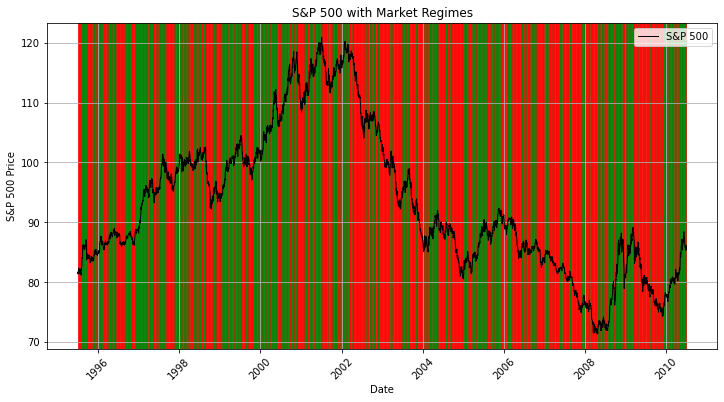

✅ Processing: 1996-01-01 to 2011-01-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 35, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.15295456676509867}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:56:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


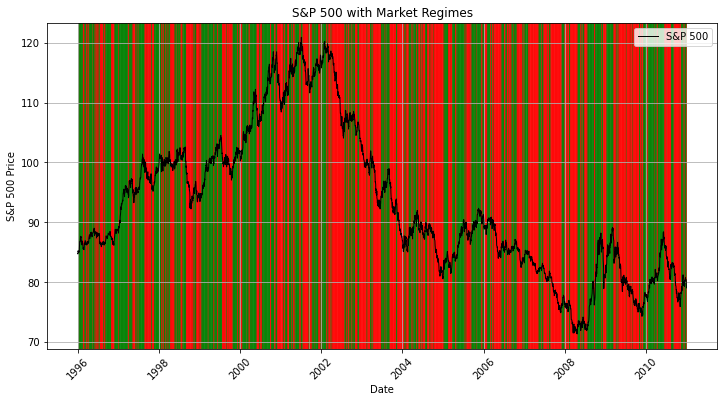

✅ Processing: 1996-07-01 to 2011-07-01
✅ Final chosen penalty: 4, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 5, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.15304340572472608}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


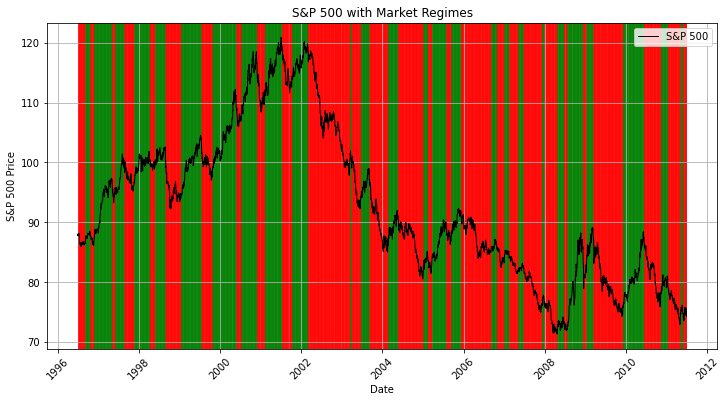

✅ Processing: 1997-01-01 to 2012-01-01
✅ Final chosen penalty: 6, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.22521203486999264}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


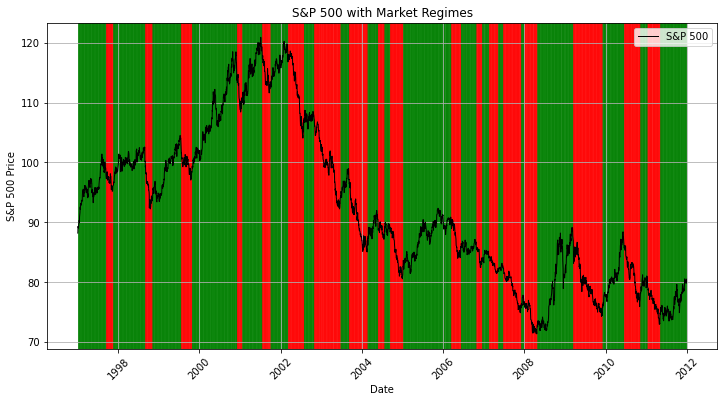

✅ Processing: 1997-07-01 to 2012-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 15, 'learning_rate': 0.05, 'strat_returns': 0.21037932215475563}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


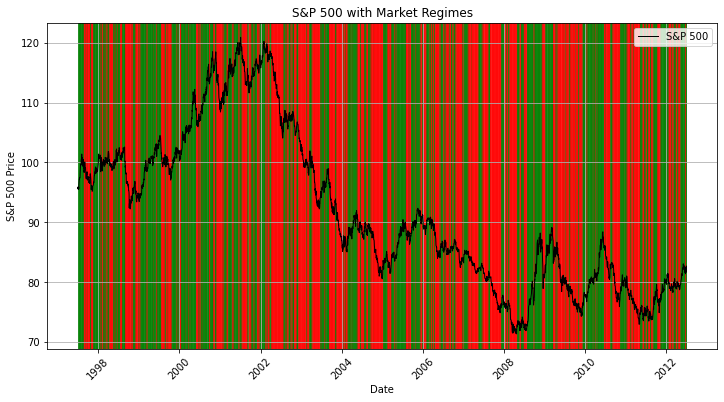

✅ Processing: 1998-01-01 to 2013-01-01
✅ Final chosen penalty: 2, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.11491560705147252}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


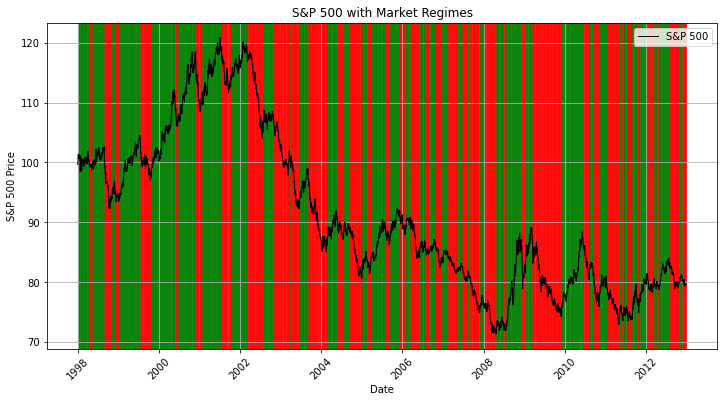

✅ Processing: 1998-07-01 to 2013-07-01
✅ Final chosen penalty: 5, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 15, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.1146346283094477}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


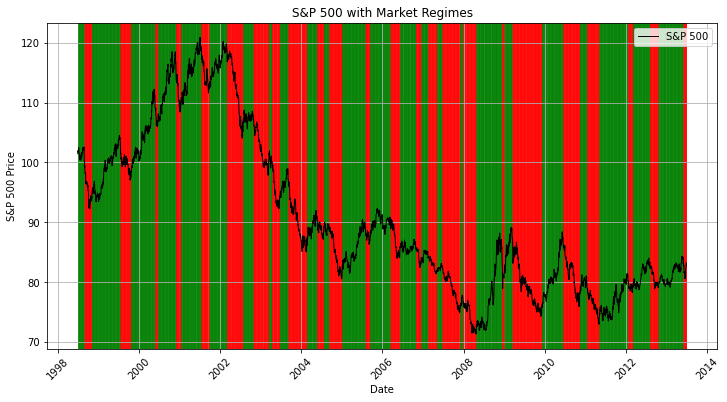

✅ Processing: 1999-01-01 to 2014-01-01
✅ Final chosen penalty: 4, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 35, 'learning_rate': 0.05, 'strat_returns': 0.13861062448653683}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


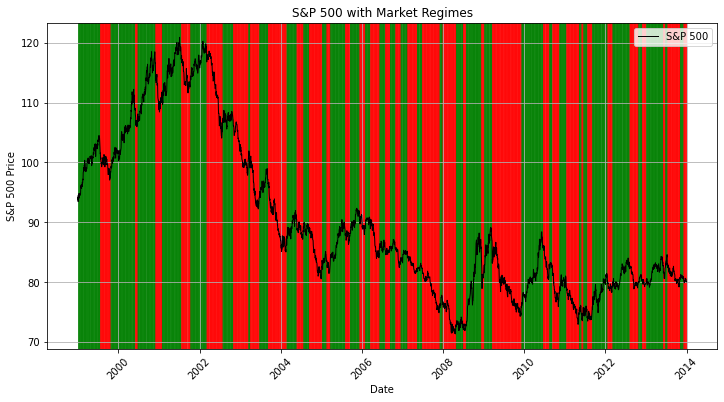

✅ Processing: 1999-07-01 to 2014-07-01
✅ Final chosen penalty: 4, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 5, 'learning_rate': 0.05, 'strat_returns': 0.027161648255856985}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


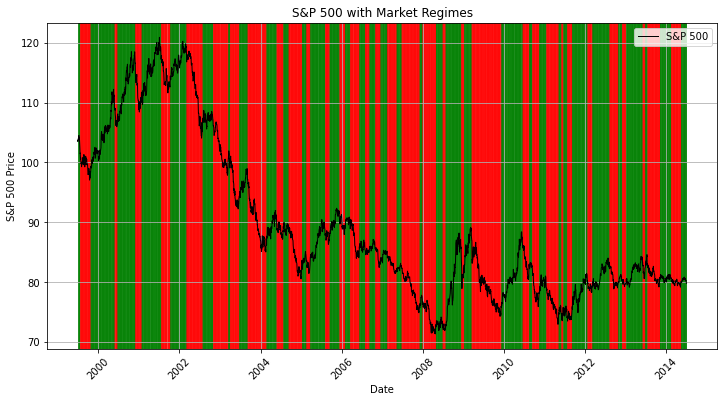

✅ Processing: 2000-01-01 to 2015-01-01
✅ Final chosen penalty: 18, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.13651634440819294}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


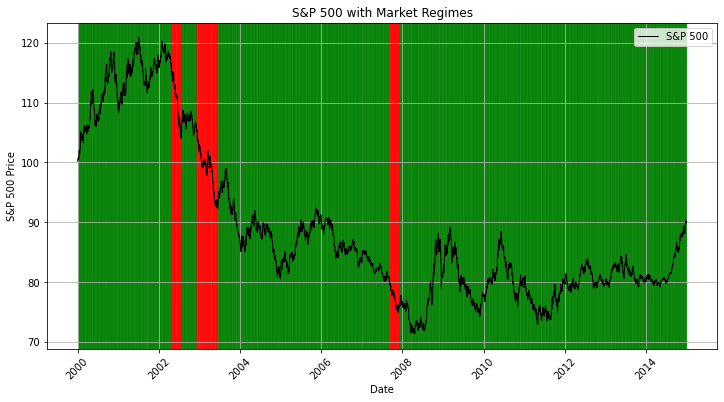

✅ Processing: 2000-07-01 to 2015-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 35, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.21176779782081145}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


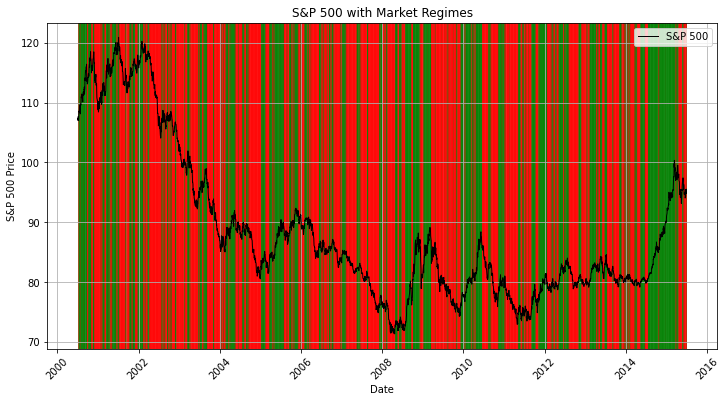

✅ Processing: 2001-01-01 to 2016-01-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.14534030948602195}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:08:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


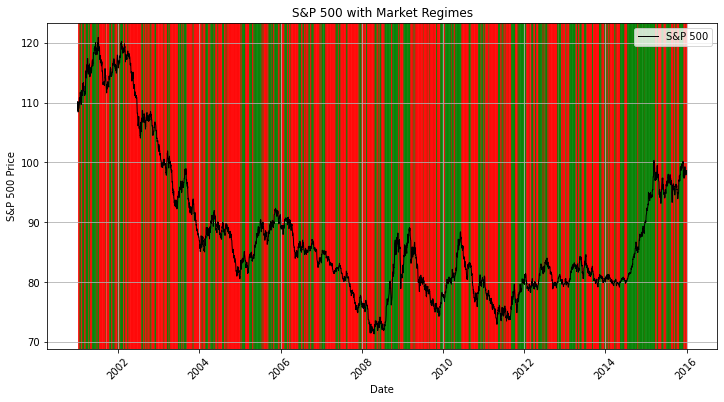

✅ Processing: 2001-07-01 to 2016-07-01
✅ Final chosen penalty: 7, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 15, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.17822941207997234}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:09:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


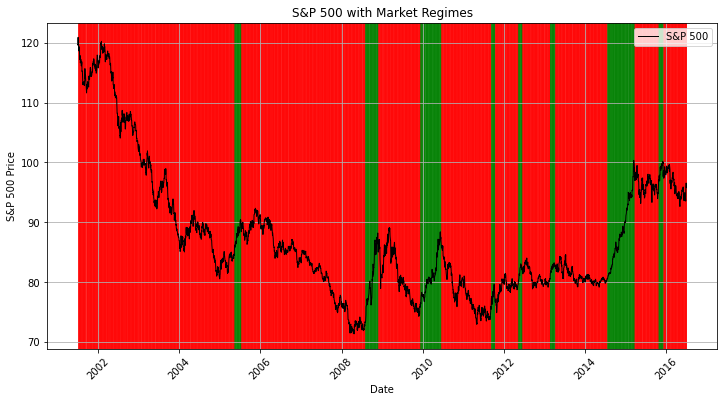

✅ Processing: 2002-01-01 to 2017-01-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 25, 'learning_rate': 0.05, 'strat_returns': 0.18383642566328673}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:10:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


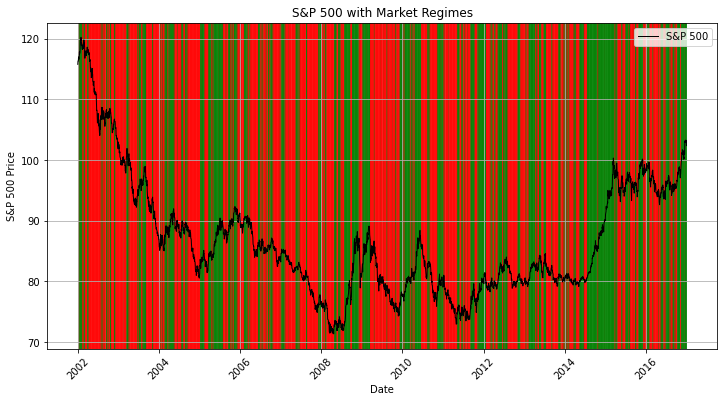

✅ Processing: 2002-07-01 to 2017-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 5, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.15502567057558214}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


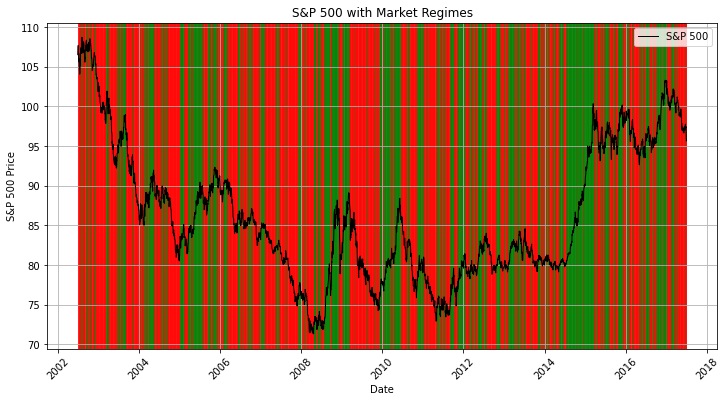

✅ Processing: 2003-01-01 to 2018-01-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 25, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.21866108225493397}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


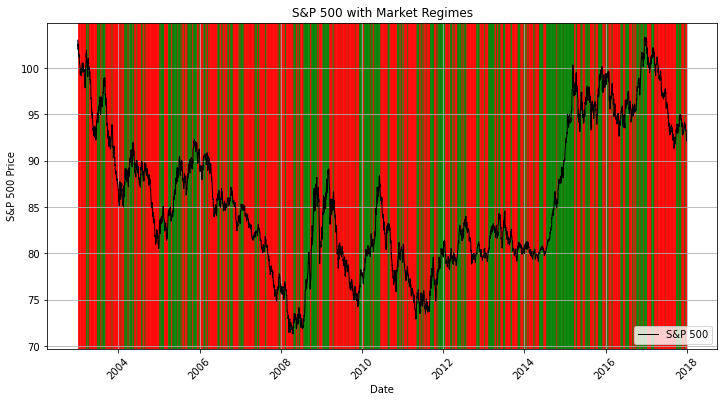

✅ Processing: 2003-07-01 to 2018-07-01
✅ Final chosen penalty: 2, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 25, 'learning_rate': 0.05, 'strat_returns': 0.26535974607343293}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:14:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


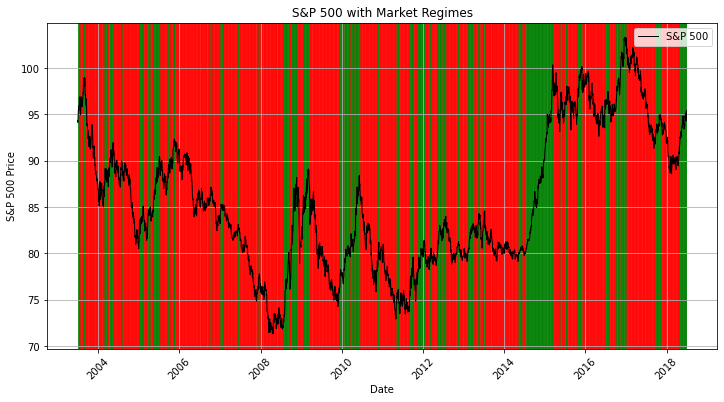

✅ Processing: 2004-01-01 to 2019-01-01
✅ Final chosen penalty: 18, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 25, 'learning_rate': 0.05, 'strat_returns': 0.09353460603146324}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:15:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


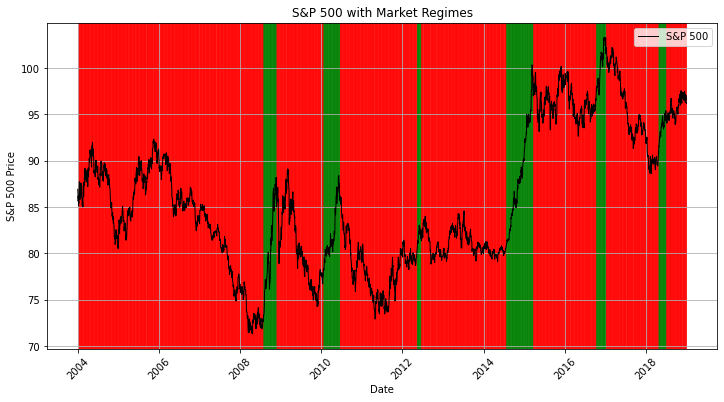

✅ Processing: 2004-07-01 to 2019-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 5, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.04666123690281365}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:16:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


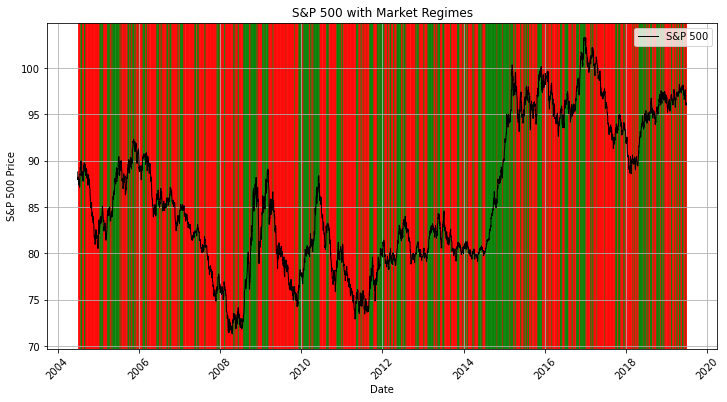

✅ Processing: 2005-01-01 to 2020-01-01
✅ Final chosen penalty: 1, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 15, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.029876261889149047}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


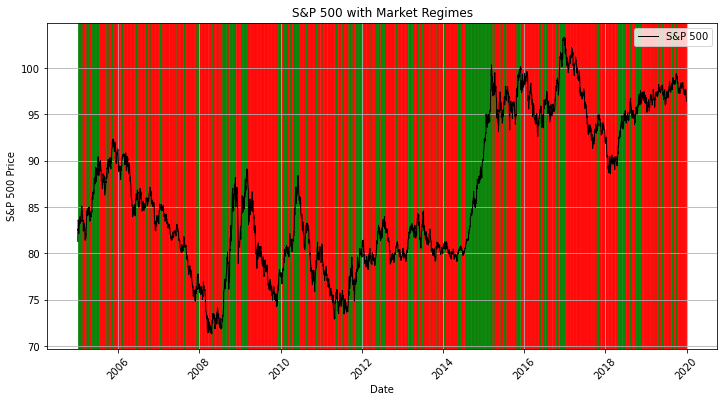

✅ Processing: 2005-07-01 to 2020-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 5, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.06542410240707608}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


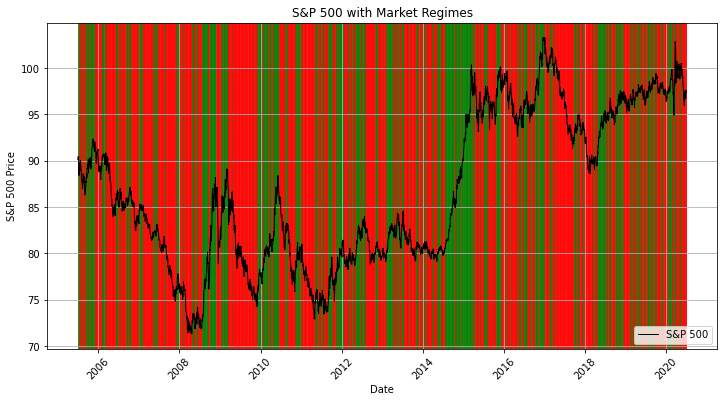

✅ Processing: 2006-01-01 to 2021-01-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 5, 'learning_rate': 0.05, 'strat_returns': 0.01808933320327233}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:19:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


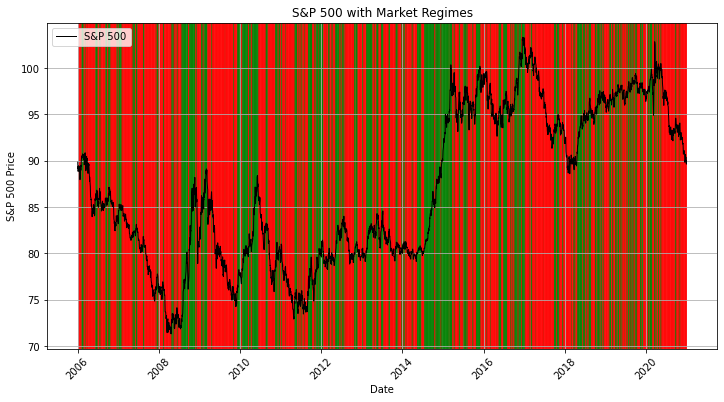

✅ Processing: 2006-07-01 to 2021-07-01
✅ Final chosen penalty: 11, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 35, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.027406403475049634}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:20:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


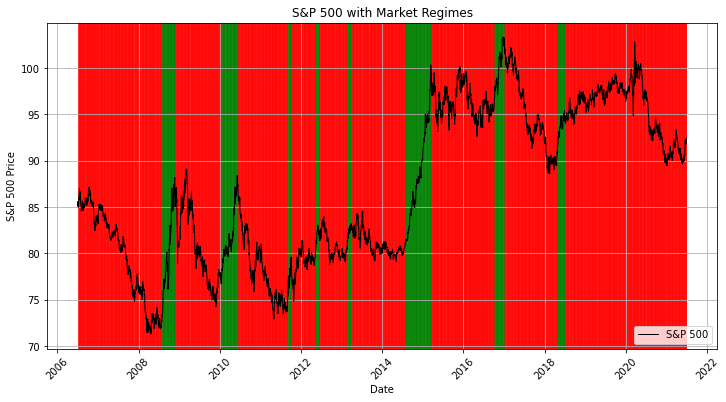

✅ Processing: 2007-01-01 to 2022-01-01
✅ Final chosen penalty: 7, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 5, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.045301016601943855}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:21:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


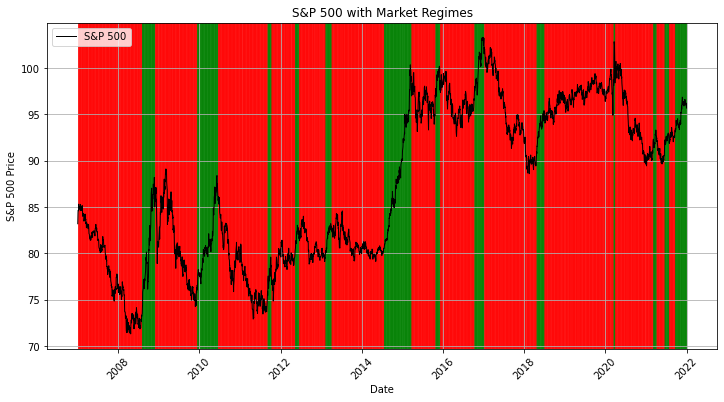

✅ Processing: 2007-07-01 to 2022-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 20, 'n_estimators': 35, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.036594879304580274}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:22:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


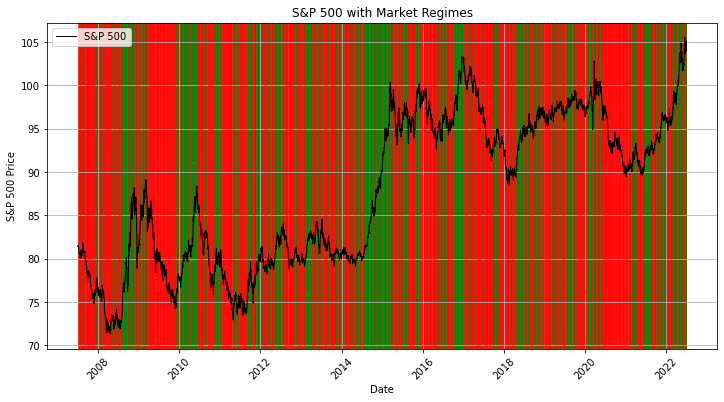

✅ Processing: 2008-01-01 to 2023-01-01
✅ Final chosen penalty: 1, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 35, 'learning_rate': 0.15000000000000002, 'strat_returns': 0.08138027896190136}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


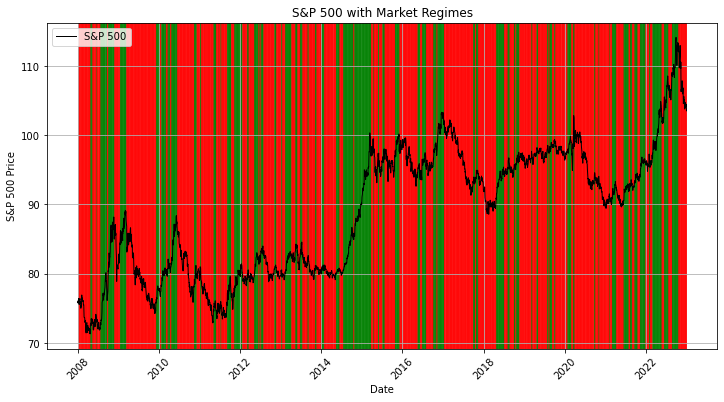

✅ Processing: 2008-07-01 to 2023-07-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 25, 'learning_rate': 0.05, 'strat_returns': 0.1067894291250413}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:24:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


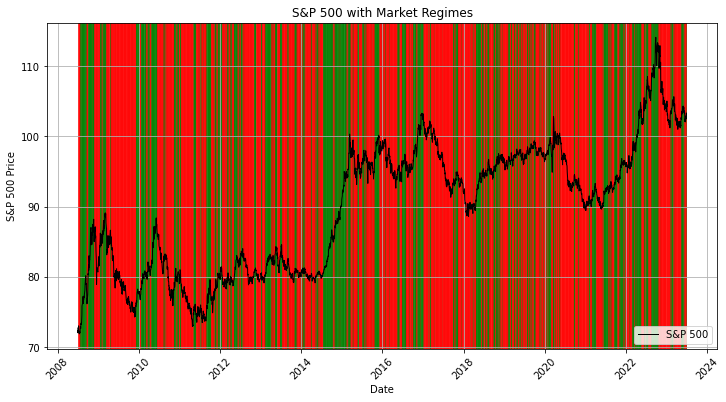

✅ Processing: 2009-01-01 to 2024-01-01
✅ Final chosen penalty: 11, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 25, 'learning_rate': 0.05, 'strat_returns': 0.10232184655721066}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:24:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


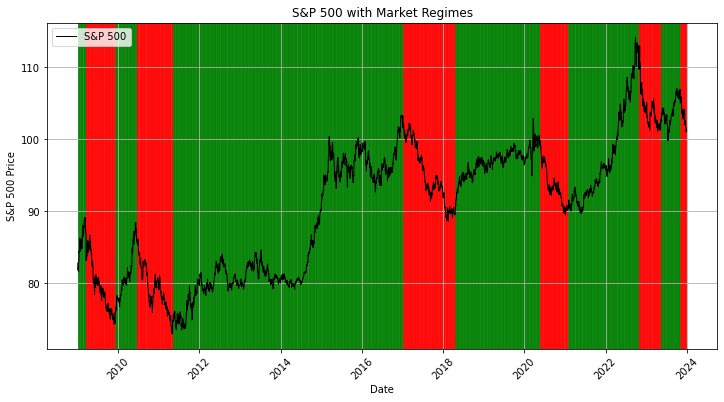

✅ Processing: 2009-07-01 to 2024-07-01
✅ Final chosen penalty: 4, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 10, 'n_estimators': 35, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.04059586142182159}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


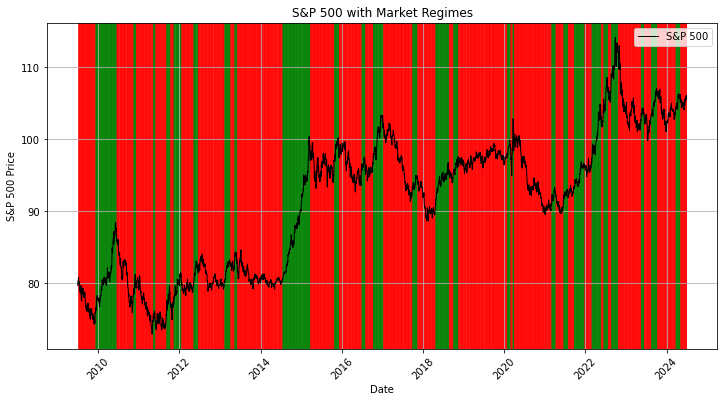

✅ Processing: 2010-01-01 to 2025-01-01
✅ Final chosen penalty: 0, based on training pattern similarity.
✅ Final chosen xgb params: {'max_depth': 5, 'n_estimators': 5, 'learning_rate': 0.25000000000000006, 'strat_returns': 0.11131817620118345}


/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:26:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "strat_returns" } are not used.

  warnings.warn(smsg, UserWarning)


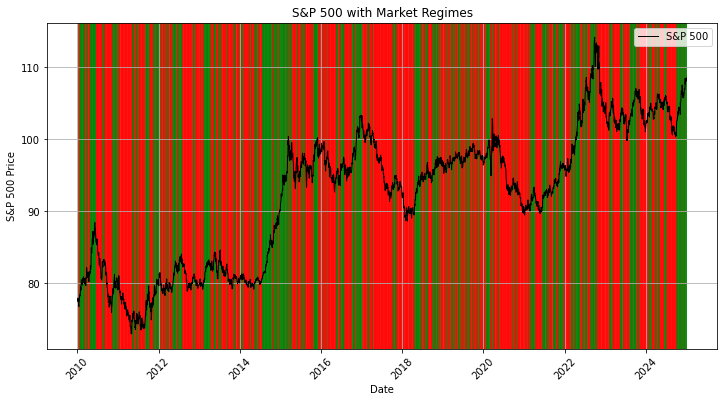

✅ Regime Forecasting Completed!


In [4]:
# 设定参数
prediction_start = "2007-01-02"
initial_train_end = (pd.to_datetime(prediction_start) - pd.DateOffset(days=1)).strftime("%Y-%m-%d")
initial_train_start = (pd.to_datetime(initial_train_end) - pd.DateOffset(years=15)).strftime("%Y-%m-%d")
prediction_end = "2025-06-10"
update_interval_months = 6
validation_years = 4

# 开始滚动训练
current_train_start = pd.to_datetime(initial_train_start)
current_train_end = pd.to_datetime(initial_train_end)
current_prediction_end = pd.to_datetime(prediction_end)
update_interval = pd.DateOffset(months=update_interval_months)

while current_train_end < current_prediction_end:
    print(f"✅ Processing: {current_train_start.date()} to {current_train_end.date()}")
    next_update_date = current_train_end + update_interval

    # 1️⃣ 训练 Jump Model (Penalized K-Means)
    df_result = train_kmeans(df_result, ASSET, feature_columns, feature_columns_xgb, 
                             current_train_start, current_train_end, validation_years=validation_years, 
                             pca=True, n_comp_kmeans = 5, next_update_date=next_update_date, 
                             pca_xgb=True, n_comp_xgb=10)
#     df_result = train_xgb(df_result, ASSET, feature_columns_xgb, current_train_start, current_train_end, validation_years=7, next_update_date=next_update_date)
    plot_market_regime(df_result, ASSET, current_train_start, current_train_end)
    
    # 滚动窗口更新
    current_train_start += update_interval
    
    current_train_end += update_interval

print("✅ Regime Forecasting Completed!")

# 回测

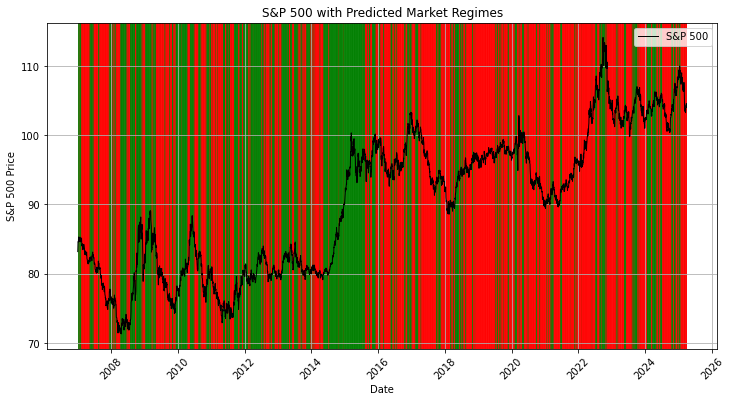

In [5]:
# 过滤数据
start = '2007-01-01'
df_view = df_result[df_result['DateTime'] >= start].reset_index()

# 创建图形
fig, ax = plt.subplots(figsize=(12, 6))

# 画出 S&P 500 走势
ax.plot(df_view['DateTime'].values, df_view[f"{ASSET}"].values, label="S&P 500", color="black", linewidth=1)

# 画出市场状态
for i in range(len(df_view) - 1):
    color = "green" if df_view["Regime_Forecast"].iloc[i] == 1 else "red"
    ax.axvspan(df_view['DateTime'].iloc[i], df_view['DateTime'].iloc[i + 1], color=color, alpha=0.3)

# 添加标题和标签
ax.set_title("S&P 500 with Predicted Market Regimes")
ax.set_xlabel("Date")
ax.set_ylabel("S&P 500 Price")
ax.legend()

# 旋转日期标签
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [6]:
# 由于代码执行状态已重置，df_view 需要重新加载
# 请上传包含 df_view 的数据文件，或者提供相关代码以重新生成 df_view

# 获取今天的日期
today = pd.Timestamp.today()

# 计算过去一个月的开始日期
one_month_ago = today - pd.DateOffset(months=1)

# 筛选过去一个月的数据
df_past_month = df_view[(df_view["DateTime"] >= one_month_ago) & (df_view["DateTime"] < today)].copy()

# 确保 Market_Regime_Num 这一列存在，并映射到文本标签
if "Market_Regime_Num" in df_past_month.columns:
    df_past_month["Market_Regime_Label"] = df_past_month["Regime_Forecast"].map({1: "Bullish", 0: "Bearish"})

# 只选择需要显示的列
columns_to_display = ["DateTime", f"{ASSET}", "Market_Regime_Label"]
df_past_month = df_past_month[columns_to_display]

df_past_month


,DateTime,USD,Market_Regime_Label
4587,2025-03-26,104.55,Bearish
4588,2025-03-27,104.07,Bearish
4589,2025-03-28,104.01,Bearish


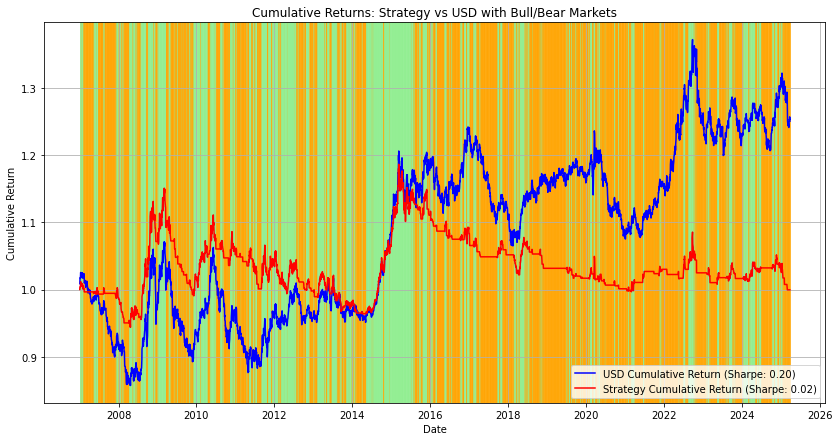

In [7]:
# 复制数据框并确保 DateTime 格式正确
df_test = df_view.copy()
df_test["DateTime"] = pd.to_datetime(df_test["DateTime"])

# 设定市场状态的基础仓位
df_test["Position"] = np.where(df_test["Regime_Forecast"] == 1, 1, 0)

# 避免未来函数问题（仓位延迟一天执行）
df_test["Position"] = df_test["Position"].shift(1)

# 计算每日收益
df_test[f"{ASSET}_Return"] = df_test[f"{ASSET}"].pct_change()
df_test["Strategy_Return"] = df_test[f"{ASSET}_Return"] * df_test["Position"]

# 计算累积收益
df_test[f"{ASSET}_Cumulative"] = (1 + df_test[f"{ASSET}_Return"]).cumprod()
df_test["Strategy_Cumulative"] = (1 + df_test["Strategy_Return"]).cumprod()

# 计算夏普比率
def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns) * np.sqrt(252)

strategy_sharpe = sharpe_ratio(df_test["Strategy_Return"].dropna())
spx_sharpe = sharpe_ratio(df_test[f"{ASSET}_Return"].dropna())

# 绘制回测结果
plt.figure(figsize=(14, 7))
plt.plot(df_test["DateTime"].values, df_test[f"{ASSET}_Cumulative"].values, label=f"{ASSET} Cumulative Return (Sharpe: {spx_sharpe:.2f})", color="blue")
plt.plot(df_test["DateTime"].values, df_test["Strategy_Cumulative"].values, label=f"Strategy Cumulative Return (Sharpe: {strategy_sharpe:.2f})", color="red")

# 画出牛市（绿色）和熊市（粉色）背景
for i in range(1, len(df_test)):
    if df_test["Regime_Forecast"].iloc[i] == 1:  # 牛市
        plt.axvspan(df_test["DateTime"].iloc[i-1], df_test["DateTime"].iloc[i], color="lightgreen", alpha=0.3)
    else:  # 熊市
        plt.axvspan(df_test["DateTime"].iloc[i-1], df_test["DateTime"].iloc[i], color="orange", alpha=0.3)

plt.title(f"Cumulative Returns: Strategy vs {ASSET} with Bull/Bear Markets")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


# 指标

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import skew


df_cleaned = df_test[[f"{ASSET}_Return", 'Strategy_Return', f"{ASSET}_Cumulative", 'Strategy_Cumulative']].dropna()


# 计算指标函数
def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else np.nan

def max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def sortino_ratio(returns):
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns)
    return np.mean(returns) / downside_std * np.sqrt(252) if downside_std != 0 else np.nan

def information_coefficient(predictions, actual_returns):
    return np.corrcoef(predictions, actual_returns)[0, 1] if len(predictions) > 1 else np.nan

def rank_information_coefficient(predictions, actual_returns):
    return np.corrcoef(pd.Series(predictions).rank(), pd.Series(actual_returns).rank())[0, 1] if len(predictions) > 1 else np.nan

def skewness(returns):
    return skew(returns, nan_policy='omit')


# 复制数据并清理 NaN
df_cleaned = df_test.dropna()

# 计算指标
# 计算指标
metrics = {
    "Metric": ["Mean Return", "Standard Deviation", "Sharpe Ratio", "Sortino Ratio", "Max Drawdown", "Skewness", "IC", "Rank IC"],
    f"{ASSET}": [
        (1 + np.mean(df_cleaned[f"{ASSET}_Return"]))**252 - 1,
        np.std(df_cleaned[f"{ASSET}_Return"]) * np.sqrt(252),
        sharpe_ratio(df_cleaned[f"{ASSET}_Return"]),
        sortino_ratio(df_cleaned[f"{ASSET}_Return"]),
        max_drawdown(df_cleaned[f"{ASSET}_Cumulative"]),
        skewness(df_cleaned[f"{ASSET}_Return"]),
        np.nan,  # SPX 无法计算 IC
        np.nan   # SPX 无法计算 Rank IC
    ],
    "Strategy": [
        (1 + np.mean(df_cleaned["Strategy_Return"]))**252 - 1,
        np.std(df_cleaned["Strategy_Return"]) * np.sqrt(252),
        sharpe_ratio(df_cleaned["Strategy_Return"]),
        sortino_ratio(df_cleaned["Strategy_Return"]),
        max_drawdown(df_cleaned["Strategy_Cumulative"]),
        skewness(df_cleaned["Strategy_Return"]),
        information_coefficient(df_cleaned["Position"], df_cleaned[f"{ASSET}_Return"]),
        rank_information_coefficient(df_cleaned["Position"], df_cleaned[f"{ASSET}_Return"])
    ]
}

# 转换为 DataFrame 并展示
metrics_df = pd.DataFrame(metrics)
metrics_df


,Metric,USD,Strategy
0,Mean Return,0.018154,0.004568
1,Standard Deviation,0.075598,0.050848
2,Sharpe Ratio,0.237995,0.089638
3,Sortino Ratio,0.357127,0.085134
4,Max Drawdown,-0.181573,-0.162160
5,Skewness,0.010524,-0.045689
6,IC,NaN,-0.004818
7,Rank IC,NaN,-0.005526


In [9]:
df_test[f'{ASSET}_Position'] = df_test['Position']
df_test[['DateTime', f'{ASSET}_Position', f'{ASSET}_Return']].to_excel(f'/Users/charlesxiong/Desktop/IBKR_algo/ode/data/{ASSET}/{ASSET}_positions.xlsx')

<ipython-input-9-016a9cae1dd0>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  df_test[['DateTime', f'{ASSET}_Position', f'{ASSET}_Return']].to_excel(f'/Users/charlesxiong/Desktop/IBKR_algo/ode/data/{ASSET}/{ASSET}_positions.xlsx')


In [10]:
df_test[['DateTime', f'{ASSET}_Position', f'{ASSET}_Return']]

,DateTime,USD_Position,USD_Return
0,2007-01-02,NaN,NaN
1,2007-01-03,0.0,0.008654
2,2007-01-04,0.0,0.004766
3,2007-01-05,1.0,0.003676
4,2007-01-08,1.0,-0.000354
...,...,...,...
4585,2025-03-24,0.0,0.001633
4586,2025-03-25,0.0,-0.000767
4587,2025-03-26,0.0,0.003552
4588,2025-03-27,0.0,-0.004591
